In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, MinMaxScaler
mms = MinMaxScaler()

In [15]:
ref = pd.read_csv('/Users/chan/Downloads/humanbrain_ref.txt',sep='\t',index_col=0)

In [25]:
bulk = pd.read_csv('/Users/chan/Desktop/pythonProject/ROSMAP/ROSMAP_lengthScaledTPM_counts.txt',
                   sep='\t',index_col=0)
bulk = np.log2(bulk+1)
bulk = pd.DataFrame(mms.fit_transform(bulk).T, index=bulk.columns, columns=bulk.index)

In [30]:
bulk['NRGN'].mean()

0.6818290168237499

In [20]:
ori_sigm = ref.groupby('Celltype').sum()
ori_sigm = np.log2(ori_sigm+1)
celltypes = ori_sigm.index
genes = ori_sigm.columns
ori_sigm = pd.DataFrame(mms.fit_transform(ori_sigm.T).T, index=celltypes, columns=genes)

In [24]:
ori_sigm['NRGN']

Celltype
Astrocytes          0.188536
Endothelial         0.059394
ExNeurons           0.441529
InNeurons           0.196776
Microglia           0.042489
OPC                 0.000000
Oligodendrocytes    0.149828
Unknown             0.000000
Name: NRGN, dtype: float64

In [2]:
data = pd.read_csv('ROSMAP_overallGEP.csv',index_col=0)

In [31]:
data.loc[celltypes]['NRGN']

Celltype
Astrocytes          1.000000
Endothelial         0.147432
ExNeurons           1.000000
InNeurons           1.000000
Microglia           0.221548
OPC                 0.245311
Oligodendrocytes    0.000000
Unknown             0.216152
Name: NRGN, dtype: float64

In [7]:
z_score = pd.DataFrame(scale(data),index=data.index,columns=data.columns)

In [14]:
def select_signature_genes(z_score):
    values = z_score.values
    signature_genes = []
    for i in range(z_score.shape[1]):
        arr = values[:,i]
        idx = arr.argsort()[-2:]
        diff = arr[idx][-1]-arr[idx[-2]]
        if diff >=1.5:
            signature_genes.append(i)
    print(len(signature_genes))
    return z_score.iloc[:,signature_genes]


In [16]:
selected = select_signature_genes(z_score)

856


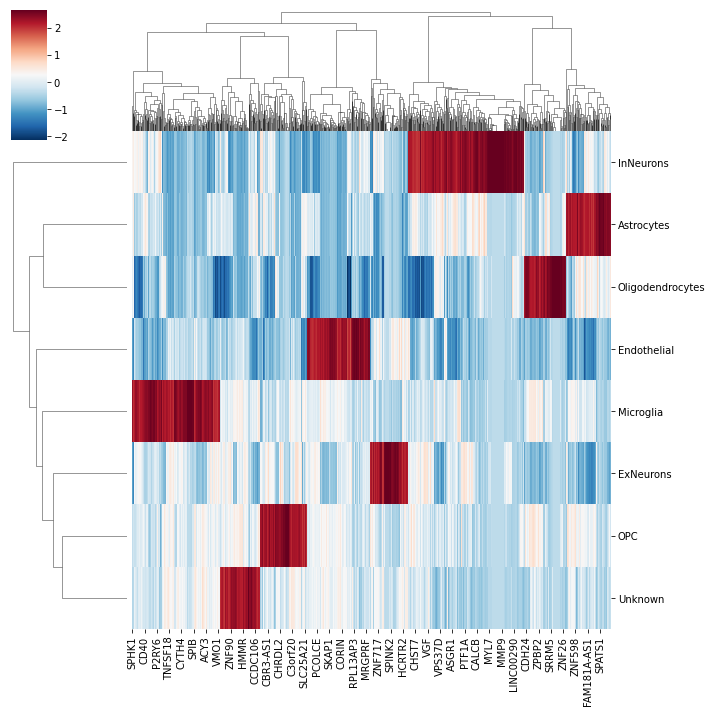

In [22]:
sns.clustermap(selected,cmap='RdBu_r')